In [1]:
import jax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import optax
import matplotlib.pyplot as plt

import itertools 

import sys
sys.path.insert(0, '..')
from prophet_utils.plot_utils import plot_iid_instance, plot_non_iid_instance

<h3>Online IID Setting </h3>

In [2]:
from prophet_utils.iid_utils import competitive_ratio_online_normalized, normalize_box

competitive_ratio_online_normalized_jit = jax.jit(competitive_ratio_online_normalized, static_argnums=(2))

In [3]:
N_iid = 1000
r_iid_init = jnp.arange(N_iid)/N_iid # Initialize with a trivial starting distribution.
p_iid_init = jnp.ones(N_iid)/N_iid

r_iid = r_iid_init.copy()
p_iid = p_iid_init.copy()

In [4]:
optimizer_iid = optax.adam(learning_rate=1e-1)
opt_state_iid = optimizer_iid.init((r_iid, p_iid))

for i in range(1000):
    v_iid, grads = jax.value_and_grad(competitive_ratio_online_normalized_jit, argnums=(0,1))(r_iid, p_iid, N_iid)
    updates_iid, opt_state_iid = optimizer_iid.update(grads, opt_state_iid)
    if i%100 == 0:
        print(v_iid)
    r_iid, p_iid = optax.apply_updates((r_iid, p_iid), updates_iid)
    
    
print(competitive_ratio_online_normalized_jit(r_iid, p_iid, N_iid))

0.999092509151939
0.7480184216002695
0.7465403679289517
0.7461910832955745
0.7460580376265393
0.7459286032504127
0.7458719139851949
0.745982806902034
0.7458970949041022
0.7458721385725292
0.7457988247217345


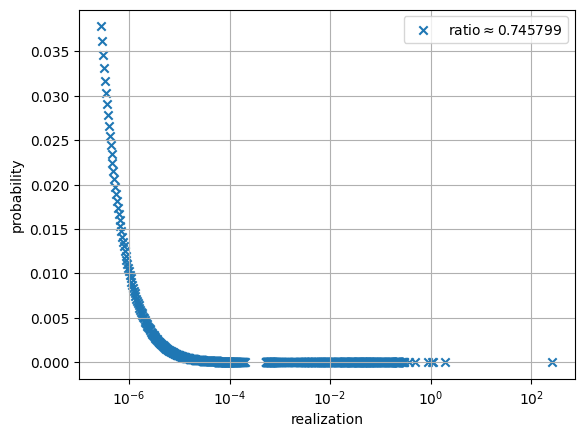

In [5]:
plot_iid_instance(*normalize_box(r_iid, p_iid), rf"ratio$\approx${v_iid:.6f}")
plt.grid()
plt.show()

<h3>Non i.i.d. setting</h3>

In [6]:
from prophet_utils.non_iid_utils import competitive_ratio_online_normalized as competitive_ratio_online_normalized_non_iid
from prophet_utils.non_iid_utils import normalize_boxes

competitive_ratio_online_normalized_non_iid_jit = jax.jit(competitive_ratio_online_normalized_non_iid)

In [7]:
m = 2
n = 2
r_non_iid = jnp.tile(jnp.arange(m), (n, 1))/m
p_non_iid = jnp.ones((n, m))/m

In [8]:
optimizer_non_iid = optax.adam(learning_rate=1e-1)
opt_state_non_iid = optimizer_non_iid.init((r_non_iid, p_non_iid))

for i in range(1000):
    v_non_iid, grads = jax.value_and_grad(competitive_ratio_online_normalized_non_iid_jit, argnums=(0,1))(r_non_iid, p_non_iid)
    updates_non_iid, opt_state_non_iid = optimizer_non_iid.update(grads, opt_state_non_iid)
    r_non_iid, p_non_iid = optax.apply_updates((r_non_iid, p_non_iid), updates_non_iid)
    if i%100 == 0:
        print(v_non_iid)

print(competitive_ratio_online_normalized_non_iid_jit(r_non_iid, p_non_iid))


1.0
0.5508408886147107
0.5172617339139454
0.5145800364822349
0.5153233817505852
0.5146210304129932
0.5200921916967702
0.5193948543824924
0.5098223007484789
0.5167577852469771
0.5119273223818874


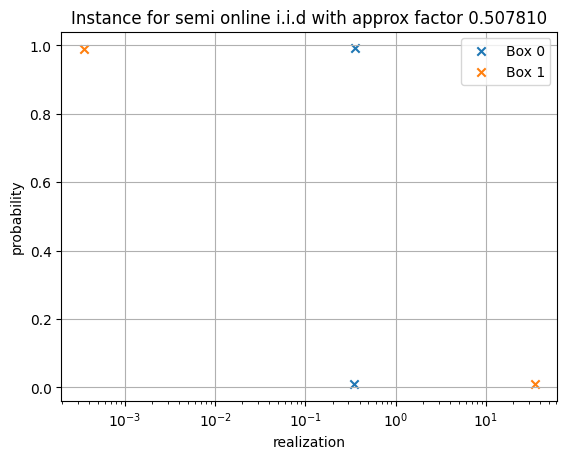

In [9]:
plot_non_iid_instance(*normalize_boxes(r_non_iid, p_non_iid), v_non_iid);

<h3>Prophet Secretary setting</h3>

In [10]:
from prophet_utils.non_iid_utils import competitive_ratio_prophet_secretary_normalized

competitive_ratio_prophet_secretary_normalized = jax.jit(competitive_ratio_prophet_secretary_normalized)

In [11]:
m = 12
n = 10
r_secretary = jnp.tile(jnp.arange(m), (n, 1))/m
p_secretary = jnp.ones((n, m))/m

In [12]:
permutations_secretary = jnp.asarray(list(itertools.permutations(range(n))))  # Careful: this requires large amount of memory!

In [13]:
optimizer_secretary = optax.adam(learning_rate=1e-1)
opt_state_secretary = optimizer_secretary.init((r_secretary, p_secretary))

for i in range(500):
    v_secretary, grads = jax.value_and_grad(competitive_ratio_prophet_secretary_normalized, argnums=(0,1))(r_secretary, p_secretary, permutations_secretary)
    updates_secretary, opt_state_secretary = optimizer_secretary.update(grads, opt_state_secretary)
    r_secretary, p_secretary = optax.apply_updates((r_secretary, p_secretary), updates_secretary)
    if i%100 == 0:
        print(v_secretary)

print(competitive_ratio_prophet_secretary_normalized(r_secretary, p_secretary, permutations_secretary))

0.9633132940933444
0.7429468461980351
0.7371388493998446
0.7352480350601495
0.7348322723632886
0.7346628996026406


<h3>Order selection setting</h3>

In [14]:
from prophet_utils.non_iid_utils import competitive_ratio_order_selection_normalized

competitive_ratio_order_selection_normalized_jit = jax.jit(competitive_ratio_order_selection_normalized)

In [15]:
m = 12
n = 10
r_os = jnp.tile(jnp.arange(m), (n, 1))/m
p_os = jnp.ones((n, m))/m

In [16]:
permutations_os = jnp.asarray(list(itertools.permutations(range(n))))

In [17]:
schedule = optax.warmup_cosine_decay_schedule(
  init_value=0.0,
  peak_value=0.2,
  warmup_steps=100,
  decay_steps=1000,
  end_value=0.0,
)

optimizer_os = optax.adam(learning_rate=schedule)

opt_state_os = optimizer_os.init((r_os, p_os))

for i in range(1000):
    v_os, grads = jax.value_and_grad(competitive_ratio_order_selection_normalized_jit, argnums=(0,1))(r_os, p_os, permutations_os)
    updates_os, opt_state_os = optimizer_os.update(grads, opt_state_os)
    r_os, p_os = optax.apply_updates((r_os, p_os), updates_os)
    if i%100 == 0:
        print(v_os)

print(competitive_ratio_order_selection_normalized_jit(r_os, p_os, permutations_os))


0.963313294093345
0.8150639433943497
0.7978288695557252
0.7925479521957711
0.7892781481129427
0.7851065983303978
0.7813516108726364
0.7801118770707994
0.7739136121452194
0.7720321633629148
0.7710180967297863
